In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
%matplotlib inline
from tensorflow import keras

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)# I. Data preprocessing

In [2]:
FEATURES_PATH = '/export/livia/home/datasets/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = '/export/livia/home/datasets/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = '/export/livia/home/datasets/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données de test

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, False)

### 1. 3 Initialisation des sous-groupes de test

In [4]:
test_images_gender, test_labels_gender, test_images_race, test_labels_race = RAFDB_subgroups_init()

### 1. 4 Séparation des sous-groupes (pour la visualisation)

In [5]:
test_images_gender['male'] = np.array(raf_db['images_gender']['male'])
test_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
test_images_gender['female'] = np.array(raf_db['images_gender']['female'])
test_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])
test_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
test_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
test_images_race['asian'] = np.array(raf_db['images_race']['asian'])
test_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
test_images_race['african'] = np.array(raf_db['images_race']['african'])
test_labels_race['african'] = np.array(raf_db['labels_race']['african'])

## 2. Balancement des données de test

In [6]:
import random

# Define the number of samples you want to generate for each subgroup
num_samples = 1000

# Initialize empty lists for the oversampled test data and labels
test_images_gender_oversampled = {'male': [], 'female': []}
test_labels_gender_oversampled = {'male': [], 'female': []}

test_images_race_oversampled = {'asian': [], 'caucasian': [], 'african': []}
test_labels_race_oversampled = {'asian': [], 'caucasian': [], 'african': []}

# Loop through the test data for gender subgroups
for gender in ['male', 'female']:
    # Get the number of samples in the original test data for this subgroup
    num_samples_gender = len(test_images_gender[gender])

    # Calculate the number of additional samples needed for this subgroup
    num_samples_needed = num_samples - num_samples_gender

    # Randomly select additional samples from the original test data for this subgroup
    idx = random.choices(range(num_samples_gender), k=num_samples_needed)
    test_images_gender_oversampled[gender] = np.concatenate([test_images_gender[gender], test_images_gender[gender][idx]])
    test_labels_gender_oversampled[gender] = np.concatenate([test_labels_gender[gender], test_labels_gender[gender][idx]])

# Loop through the test data for race subgroups
for race in ['asian', 'caucasian', 'african']:
    # Get the number of samples in the original test data for this subgroup
    num_samples_race = len(test_images_race[race])

    # Calculate the number of additional samples needed for this subgroup
    num_samples_needed = num_samples - num_samples_race

    # Randomly select additional samples from the original test data for this subgroup
    idx = random.choices(range(num_samples_race), k=num_samples_needed)
    test_images_race_oversampled[race] = np.concatenate([test_images_race[race], test_images_race[race][idx]])
    test_labels_race_oversampled[race] = np.concatenate([test_labels_race[race], test_labels_race[race][idx]])

In [7]:
for gender in ['male', 'female']:
    test_images_gender_oversampled[gender] = test_images_gender_oversampled[gender][:num_samples]
    test_labels_gender_oversampled[gender] = test_labels_gender_oversampled[gender][:num_samples]
    
for race in ['african', 'asian', 'caucasian']:
    test_images_race_oversampled[race] = test_images_race_oversampled[race][:num_samples]
    test_labels_race_oversampled[race] = test_labels_race_oversampled[race][:num_samples]

In [8]:
print(len(test_images_gender_oversampled['male']))
print(len(test_images_gender_oversampled['female']))
print(len(test_images_race_oversampled['asian']))
print(len(test_images_race_oversampled['caucasian']))
print(len(test_images_race_oversampled['african']))

1000
1000
1000
1000
1000


## 3. Chargement des variantes de VGG19

In [9]:
vanilla_resnet152 = keras.models.load_model('checkpointsv2/best_vanilla_ResNet152.h5')
fine_tuned_resnet152 = keras.models.load_model('checkpointsv2/best_fine_tuned_ResNet152.h5')
fine_tuned_augmented_resnet152 = keras.models.load_model('checkpointsv2/Fine-Tuned_Augmented_ResNet152.h5')
augmented_balanced_resnet152 = keras.models.load_model('checkpointsv2/best_aumented_balanced_ResNet152.h5')

In [10]:
models = {
            'Resnet152' : vanilla_resnet152,
            'Fine tuned Resnet152' : fine_tuned_resnet152,
            'Fine tuned and Augmented Resnet152' : fine_tuned_augmented_resnet152,
            'Fine tuned Augmented and Balanced Resnet152' : augmented_balanced_resnet152
         }

## 4. Évaluation des performances inter-groupes

In [11]:
# Initialize metrics' dictionaries
metrics_models = {}
race_precision = {}
race_recall = {}
race_f1 = {}

In [12]:
for model_name, model in models.items():
    
    print(f'Evaluating {model_name}')

    # Evaluate the model on the male test data
    male_test_loss, male_test_acc = model.evaluate(test_images_gender_oversampled['male'], test_labels_gender_oversampled['male'], verbose=0)
    
    # Evaluate the model on the female test data
    female_test_loss, female_test_acc = model.evaluate(test_images_gender_oversampled['female'], test_labels_gender_oversampled['female'], verbose=0)

    # Evaluate the model on the caucasian test data
    caucasian_test_loss, caucasian_test_acc = model.evaluate(test_images_race_oversampled['caucasian'], test_labels_race_oversampled['caucasian'], verbose=0)

    # Evaluate the model on the african test data
    african_test_loss, african_test_acc = model.evaluate(test_images_race_oversampled['african'], test_labels_race_oversampled['african'], verbose=0)

    # Evaluate the model on the asian test data
    asian_test_loss, asian_test_acc = model.evaluate(test_images_race_oversampled['asian'], test_labels_race_oversampled['asian'], verbose=0)
    
    print(f'Computing metrics for {model_name}')

    # Calculate metrics for male and female subgroups
    y_male_pred_classes = np.argmax(model.predict(test_images_gender_oversampled['male']), axis=1)
    y_female_pred_classes = np.argmax(model.predict(test_images_gender_oversampled['female']), axis=1)
    male_precision = precision_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    male_recall = recall_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    male_f1 = f1_score(np.argmax(test_labels_gender_oversampled['male'], axis=1), y_male_pred_classes, average='weighted')
    female_precision = precision_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
    female_recall = recall_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
    female_f1 = f1_score(np.argmax(test_labels_gender_oversampled['female'], axis=1), y_female_pred_classes, average='weighted')
        

    # Calculate metrics for race subgroups
    race_precision = {}
    race_recall = {}
    race_f1 = {}
    for r in ['african', 'caucasian', 'asian']:
        y_pred_classes = np.argmax(model.predict(test_images_race_oversampled[r]), axis=1)
        y_true_classes = np.argmax(test_labels_race_oversampled[r], axis=1)
        race_precision[r] = precision_score(y_true_classes, y_pred_classes, average='weighted')
        race_recall[r] = recall_score(y_true_classes, y_pred_classes, average='weighted')
        race_f1[r] = f1_score(y_true_classes, y_pred_classes, average='weighted')
        
    metrics_models[model_name] = {
                                    'accuracy':
                                     {
                                        'race': {
                                            'caucasian': caucasian_test_acc,
                                            'african': african_test_acc,
                                            'asian': asian_test_acc
                                        },
                                         'gender': {
                                             'male': male_test_acc, 
                                             'female': female_test_acc
                                         }                                   
                                     },
                                    'precision': {
                                        'race': race_precision,
                                        'gender': {
                                            'male': male_precision,
                                            'female': female_precision
                                            }
                                    },
                                    'recall': {
                                        'race': race_recall,
                                        'gender': {
                                            'male': male_recall,
                                            'female': female_recall       
                                        }
                                    },
                                    'f1': {
                                        'race':race_f1,
                                        'gender': {
                                            'male': male_f1,
                                            'female': female_f1
                                        }
                                    }
                                }

Evaluating Resnet152
Computing metrics for Resnet152
Evaluating Fine tuned Resnet152
Computing metrics for Fine tuned Resnet152
Evaluating Fine tuned and Augmented Resnet152
Computing metrics for Fine tuned and Augmented Resnet152
Evaluating Fine tuned Augmented and Balanced Resnet152
Computing metrics for Fine tuned Augmented and Balanced Resnet152


### 4. 1 Affichage des métriques des modèles de CNN

In [13]:
metrics_models

{'Resnet152': {'accuracy': {'race': {'caucasian': 0.6800000071525574,
    'african': 0.6629999876022339,
    'asian': 0.6629999876022339},
   'gender': {'male': 0.6200000047683716, 'female': 0.6899999976158142}},
  'precision': {'race': {'african': 0.6713202291349812,
    'caucasian': 0.6734403748767013,
    'asian': 0.6691944440546296},
   'gender': {'male': 0.6194942387009753, 'female': 0.6857878450717195}},
  'recall': {'race': {'african': 0.663, 'caucasian': 0.68, 'asian': 0.663},
   'gender': {'male': 0.62, 'female': 0.69}},
  'f1': {'race': {'african': 0.6656757107450368,
    'caucasian': 0.673440833978202,
    'asian': 0.6589944896175743},
   'gender': {'male': 0.616280389492515, 'female': 0.684882698041988}}},
 'Fine tuned Resnet152': {'accuracy': {'race': {'caucasian': 0.6740000247955322,
    'african': 0.6309999823570251,
    'asian': 0.6230000257492065},
   'gender': {'male': 0.6380000114440918, 'female': 0.6700000166893005}},
  'precision': {'race': {'african': 0.6693464495

In [14]:
# Accuracy metric for each model on race
for key, value in metrics_models.items():
    print(f'Model: {key}')
    print(value['accuracy']['race'])

Model: Resnet152
{'caucasian': 0.6800000071525574, 'african': 0.6629999876022339, 'asian': 0.6629999876022339}
Model: Fine tuned Resnet152
{'caucasian': 0.6740000247955322, 'african': 0.6309999823570251, 'asian': 0.6230000257492065}
Model: Fine tuned and Augmented Resnet152
{'caucasian': 0.6859999895095825, 'african': 0.6930000185966492, 'asian': 0.6759999990463257}
Model: Fine tuned Augmented and Balanced Resnet152
{'caucasian': 0.6909999847412109, 'african': 0.7110000252723694, 'asian': 0.6930000185966492}


In [15]:
# Accuracy metric for each model on gender
for key, value in metrics_models.items():
    print(f'Model: {key}')
    print(value['accuracy']['gender'])

Model: Resnet152
{'male': 0.6200000047683716, 'female': 0.6899999976158142}
Model: Fine tuned Resnet152
{'male': 0.6380000114440918, 'female': 0.6700000166893005}
Model: Fine tuned and Augmented Resnet152
{'male': 0.6499999761581421, 'female': 0.7039999961853027}
Model: Fine tuned Augmented and Balanced Resnet152
{'male': 0.6660000085830688, 'female': 0.7049999833106995}


### 4. 2 Calcul des matrices de confusion

In [16]:
conf_gender = {}
conf_race = {}

for model_name, model_ in models.items():
    gender_dict = {}
    race_dict = {}

    for gender in ['male', 'female']:
        y_pred = model_.predict(test_images_gender_oversampled[gender])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(test_labels_gender_oversampled[gender], axis=1)
        gender_dict[gender] = confusion_matrix(y_true, y_pred_classes)
        
    conf_gender[model_name] = gender_dict
    
    
    for r in ['african', 'caucasian', 'asian']:
        y_pred = model_.predict(test_images_race_oversampled[r])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(test_labels_race_oversampled[r], axis=1)
        race_dict[r] = confusion_matrix(y_true, y_pred_classes)
        
    conf_race[model_name] = race_dict

In [17]:
conf_gender

{'Resnet152': {'male': array([[ 52,   3,   2,  17,  10,   7,  19],
         [  3,  17,   2,   6,   3,   5,   0],
         [  2,   0,  14,   8,  10,   4,  18],
         [  5,   1,   8, 268,  17,   9,  28],
         [  3,   0,   5,  20,  74,   5,  14],
         [  1,   3,   6,  15,   8,  44,   9],
         [ 15,   3,  16,  37,  28,   5, 151]]),
  'female': array([[ 68,   0,   4,  10,   8,   1,  15],
         [  1,   7,   0,   5,   2,   0,   2],
         [  4,   0,  10,  17,  14,   0,   6],
         [  8,   0,   7, 340,  21,   6,  24],
         [  3,   0,   6,  26, 122,   5,  21],
         [  1,   0,   2,  10,   2,  14,   1],
         [ 13,   0,   9,  23,  30,   3, 129]])},
 'Fine tuned Resnet152': {'male': array([[ 69,   5,   2,   6,   7,   5,  16],
         [  9,  18,   0,   0,   2,   4,   3],
         [  5,   1,  18,  10,   5,   4,  13],
         [ 11,   4,  12, 255,  15,   7,  32],
         [  4,   2,  10,  13,  72,   1,  19],
         [  4,   4,   2,   4,  10,  51,  11],
         [ 2

In [18]:
conf_race

{'Resnet152': {'african': array([[ 28,   0,   6,   4,   9,   0,   2],
         [  3,   3,   1,   3,   5,   0,   0],
         [  3,   0,  16,   7,  12,   2,  15],
         [  3,   0,  15, 302,  33,   9,  31],
         [  7,   3,   4,  34, 120,   2,  25],
         [  0,   2,   0,   0,   1,  14,   6],
         [ 16,   0,  16,  22,  31,   5, 180]]),
  'caucasian': array([[ 70,   1,   4,  12,   6,   5,  22],
         [  2,  14,   0,   7,   0,   4,   1],
         [  4,   0,  13,  13,  14,   1,  11],
         [  8,   0,   5, 310,  13,   6,  27],
         [  1,   0,   6,  21, 104,   5,  16],
         [  1,   2,   4,  18,   5,  30,   6],
         [ 11,   1,   9,  21,  24,   3, 139]]),
  'asian': array([[ 60,   0,   0,  24,  15,   0,  12],
         [  5,  11,   0,   0,   8,   0,   8],
         [  0,   0,   7,   8,   9,   0,   8],
         [ 14,   0,   4, 357,  12,   6,  35],
         [  4,   0,  12,  26,  81,  22,   0],
         [  0,   0,   0,   4,   7,  24,   4],
         [ 15,   0,   9,  48, 

## 5. Visualisation et comparaison des performances des modèles sur les sous-groupes (toutes les métriques)

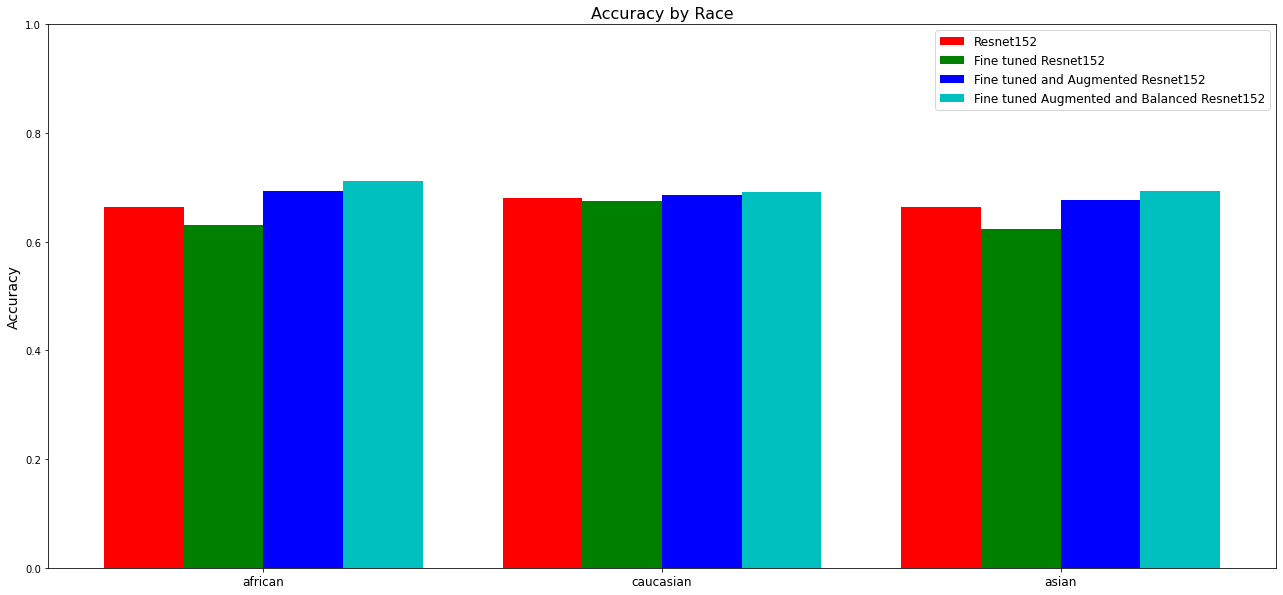

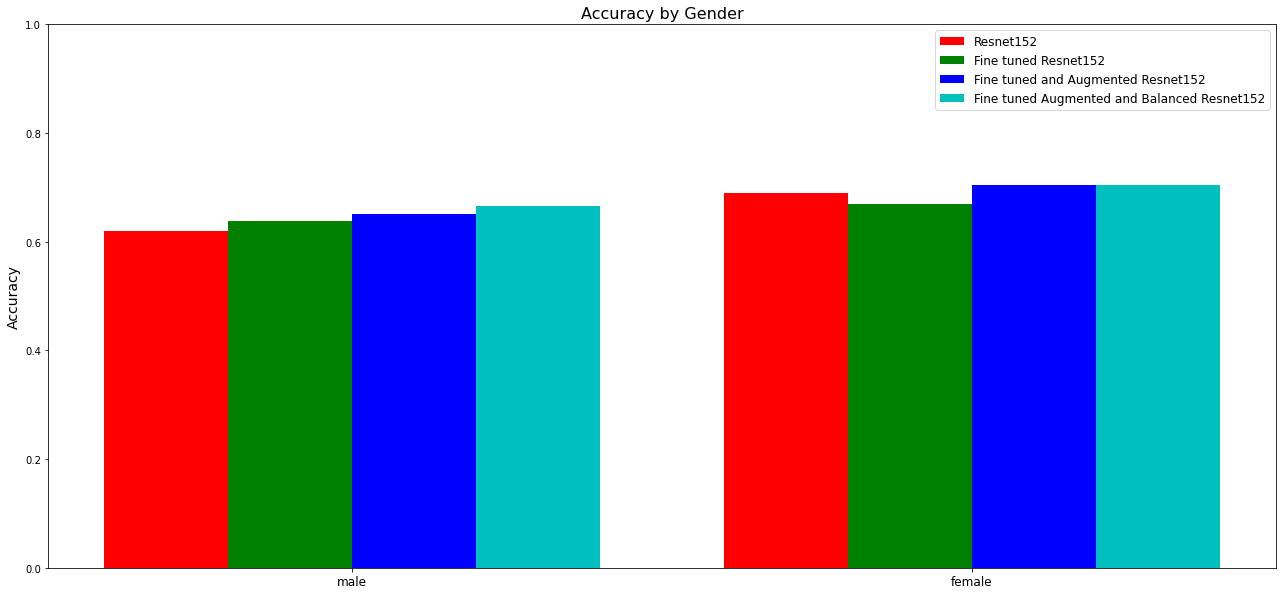

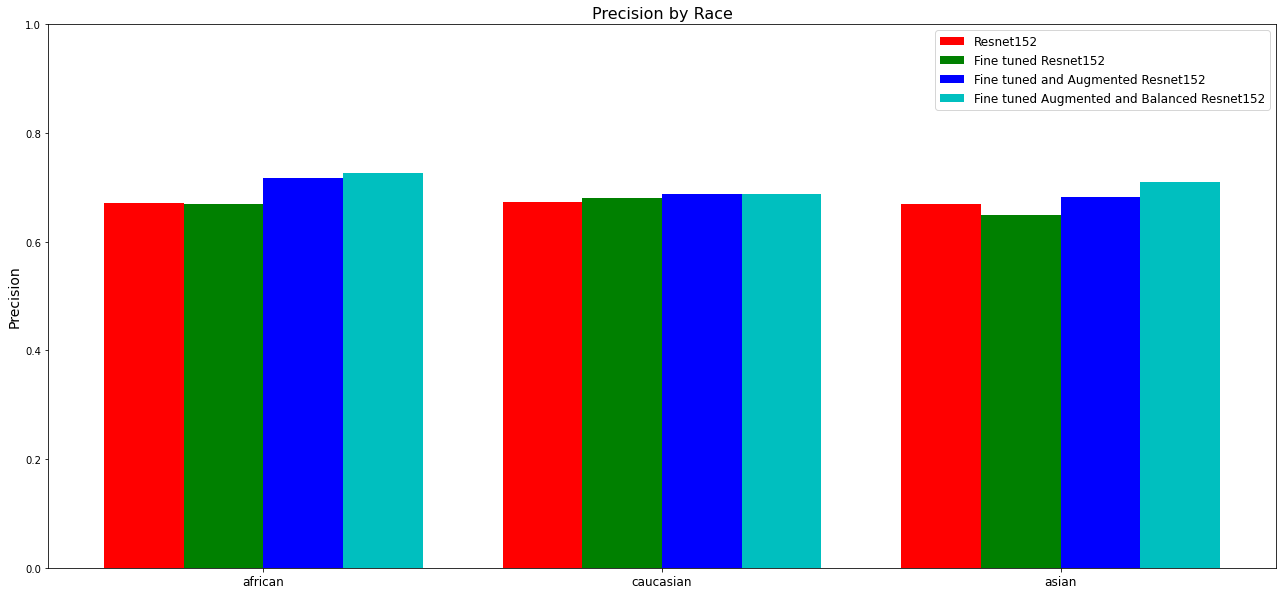

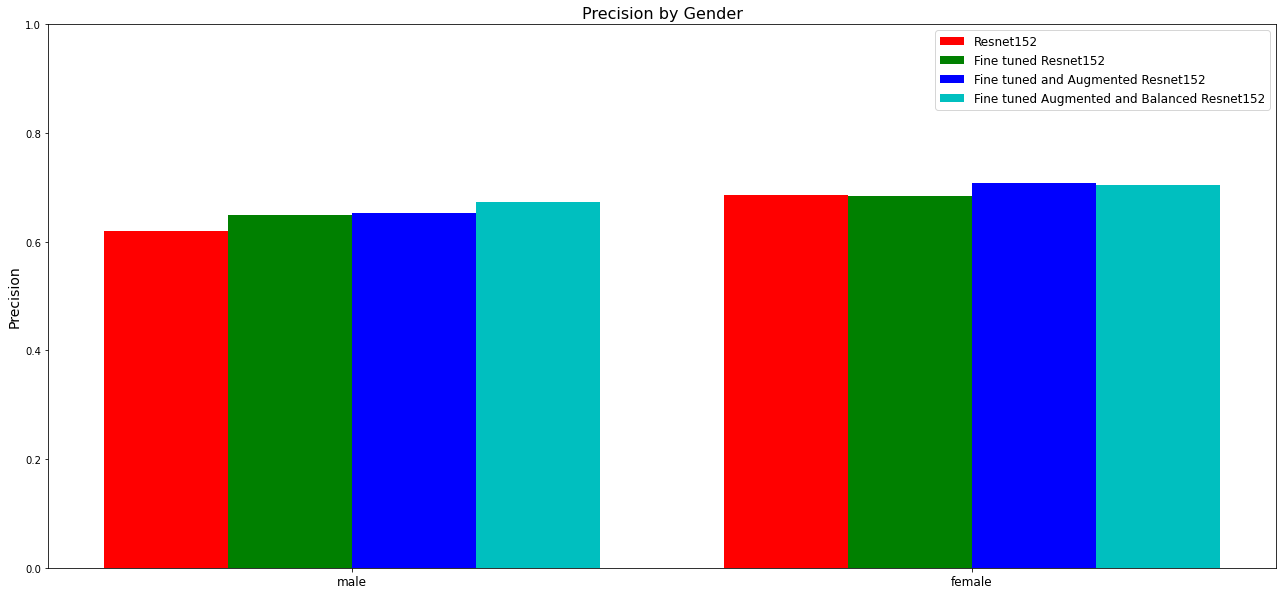

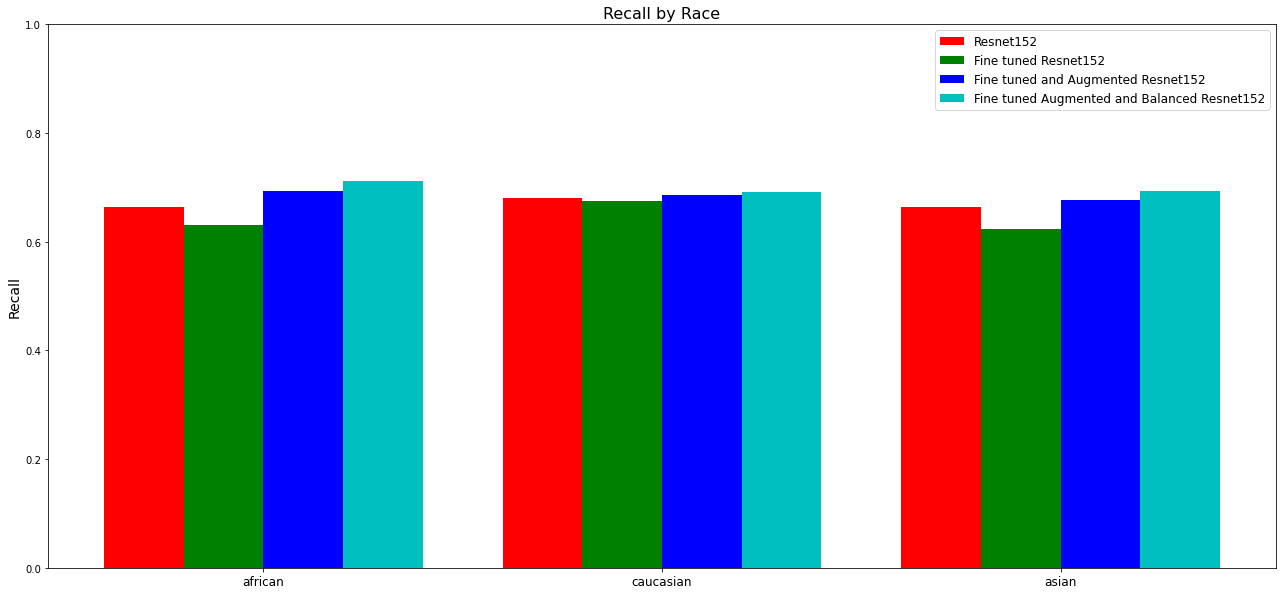

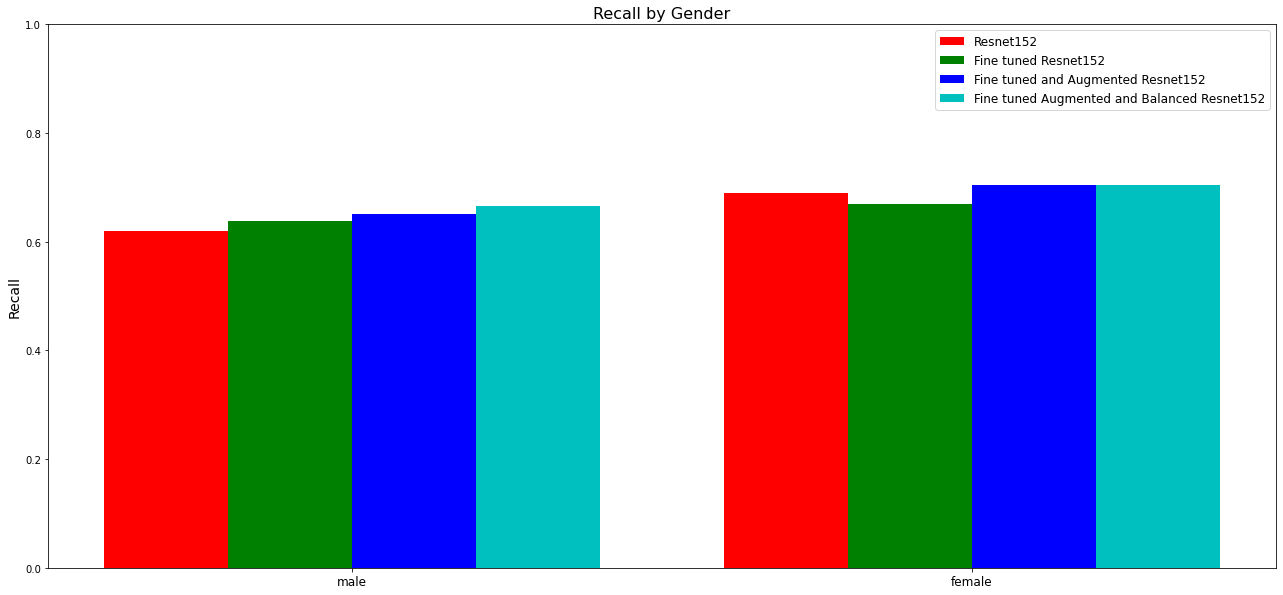

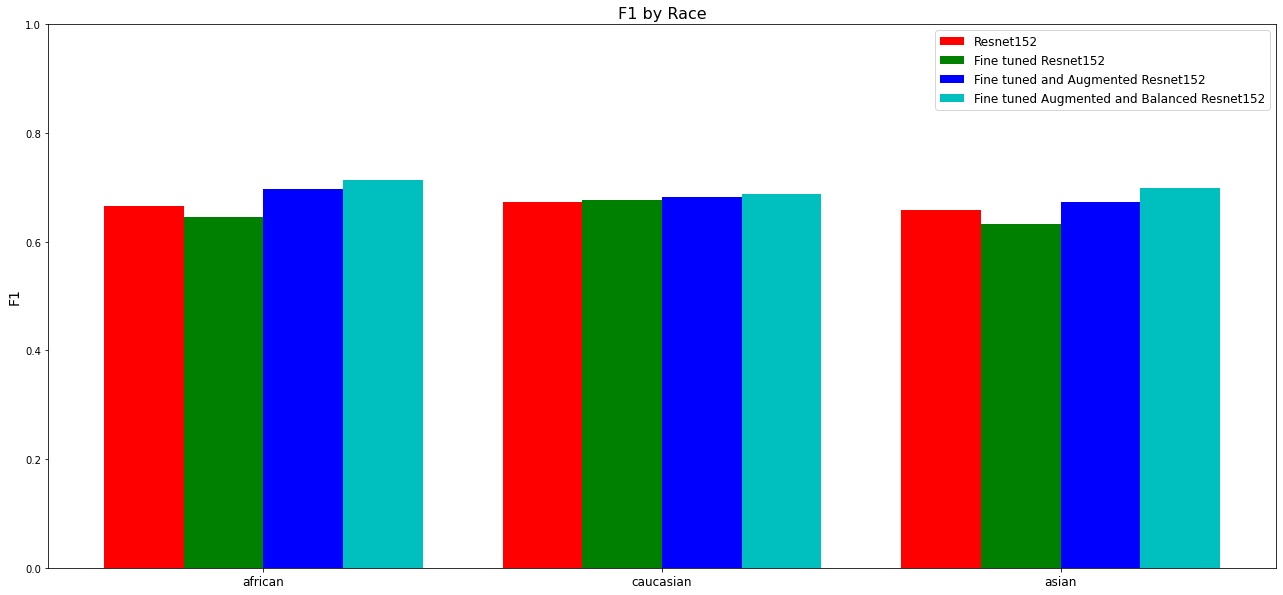

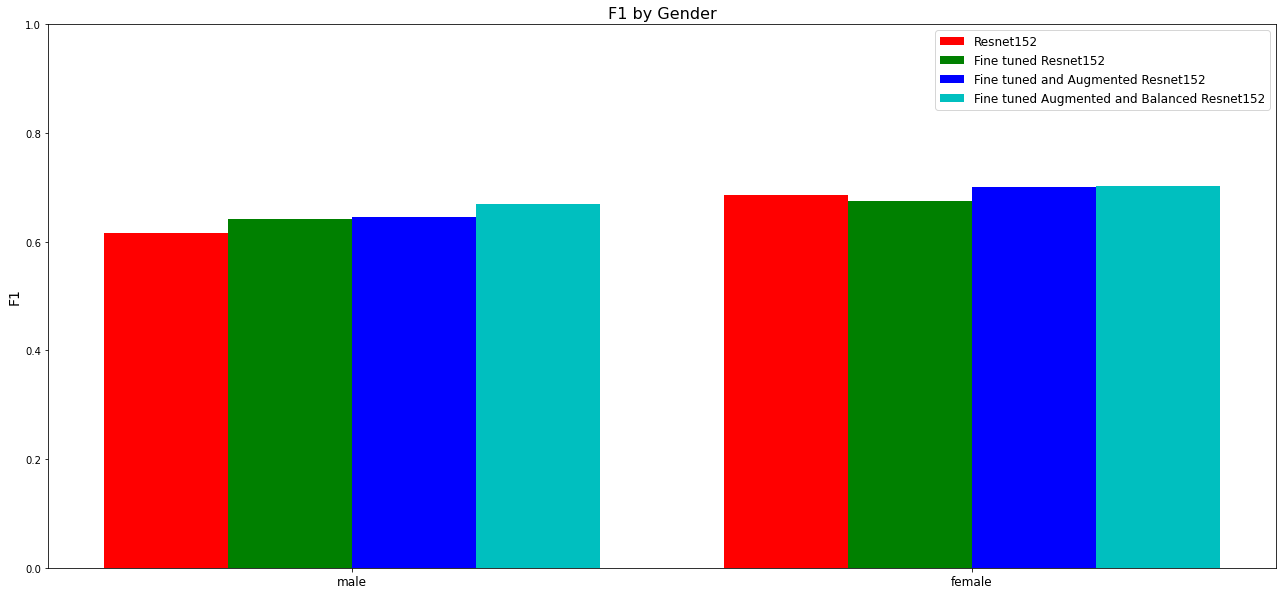

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#models_names = ['VGG19', 'Fine tuned VGG19', 'Fine tuned and Augmented VGG19', 'Augmented Balanced VGG19']
models_names = ['Resnet152', 'Fine tuned Resnet152', 'Fine tuned and Augmented Resnet152','Fine tuned Augmented and Balanced Resnet152']

metrics = ['accuracy', 'precision', 'recall', 'f1']
race_groups = ['african', 'caucasian', 'asian']
gender_groups = ['male', 'female']

colors = ['r', 'g', 'b', 'c']  # Assign colors for each model

# Calculate the total width for each group of bars
total_width = 0.8
n_models = len(models_names)
width = total_width / n_models

for metric in metrics:
    # Create separate plots for race and gender metrics
    fig_race, ax_race = plt.subplots(figsize=(22, 10))
    fig_gender, ax_gender = plt.subplots(figsize=(22, 10))
    
    # Set title and y-axis label for race plot
    ax_race.set_title(f'{metric.capitalize()} by Race', fontsize=16)
    ax_race.set_ylabel(metric.capitalize(), fontsize=14)
    ax_race.set_ylim([0, 1])
    
    # Set title and y-axis label for gender plot
    ax_gender.set_title(f'{metric.capitalize()} by Gender', fontsize=16)
    ax_gender.set_ylabel(metric.capitalize(), fontsize=14)
    ax_gender.set_ylim([0, 1])
    
    for i, model in enumerate(models_names):
        # Get race values for the current model and metric
        race_values = []
        for group in race_groups:
            if 'race' in metrics_models[model][metric] and group in metrics_models[model][metric]['race']:
                value = metrics_models[model][metric]['race'][group]
            else:
                value = 0
            race_values.append(value)
        race_color = colors[i]
        x_race = np.arange(len(race_groups)) + i * width - (total_width - width) / 2  # Calculate the x position for each bar
        ax_race.bar(x_race, race_values, width, color=race_color, label=model)
        
        # Get gender values for the current model and metric
        gender_values = []
        for group in gender_groups:
            if 'gender' in metrics_models[model][metric] and group in metrics_models[model][metric]['gender']:
                value = metrics_models[model][metric]['gender'][group]
            else:
                value = 0
            gender_values.append(value)
        gender_color = colors[i]
        x_gender = np.arange(len(gender_groups)) + i * width - (total_width - width) / 2  # Calculate the x position for each bar
        ax_gender.bar(x_gender, gender_values, width, color=gender_color, label=model)
    
    # Set x-axis labels and ticks for race plot
    ax_race.set_xticks(np.arange(len(race_groups)))
    ax_race.set_xticklabels(race_groups, fontsize=12)
    ax_race.legend(fontsize=12)
    
    # Set x-axis labels and ticks for gender plot
    ax_gender.set_xticks(np.arange(len(gender_groups)))
    ax_gender.set_xticklabels(gender_groups, fontsize=12)
    ax_gender.legend(fontsize=12)
    plt.show()
